In [1]:
import sys
from tvb.simulator.lab import *
import scipy.stats
import time
import utils
import numpy as np


/Users/dominik/anaconda3/envs/brain/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def run_sim(conn, cs, D, cv=3.0, dt=0.5, simlen=1e3):
    sim = simulator.Simulator(
        model=models.Generic2dOscillator(a=np.array([0.0])),
        connectivity=conn,
        coupling=coupling.Linear(a=np.array([cs])),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=np.array([D]))),
        monitors=(monitors.TemporalAverage(period=5.0),) # 200 Hz
    )
    sim.configure()
    (t, y), = sim.run(simulation_length=simlen)
    return t, y[:, 0, :, 0]

In [4]:
conn = connectivity.Connectivity.from_file()

WARNING  File 'hemispheres' not found in ZIP.


In [5]:
tic = time.time()
t, y = run_sim(conn, 6e-2, 5e-4, simlen=2*60e3)
print(f'simulation took {time.time() - tic} seconds.')

simulation took 19.67990016937256 seconds.


In [6]:
# create windows
cs = []
for i in range(int(t[-1]/1e3)):
    cs.append(np.corrcoef(y[(t>(i*1e3))*(t<(1e3*(i+1)))].T))
cs = np.array(cs)
cs.shape

(119, 76, 76)

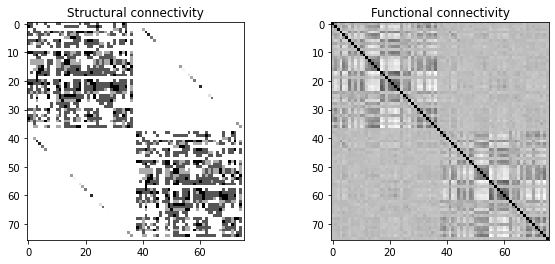

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Structural connectivity')
plt.imshow(conn.weights, cmap='binary', interpolation='none')
plt.subplot(122)
plt.title('Functional connectivity')
plt.imshow(cs[2:].mean(axis=0), cmap='binary', interpolation='none')
plt.show()

In [8]:
ctx = cortex.Cortex.from_file()

In [9]:
ctx.region_mapping_data.connectivity = conn

In [10]:
def plot_roi_corr_map(region_name):
    roi = list(conn.ordered_labels).index(region_name)
    cs_m = cs[2:].mean(axis=0)
    region_indices = ctx.region_mapping
    utils.multiview(ctx, cs_m[roi][region_indices], shaded=False, suptitle=region_name, figsize=(10, 5))

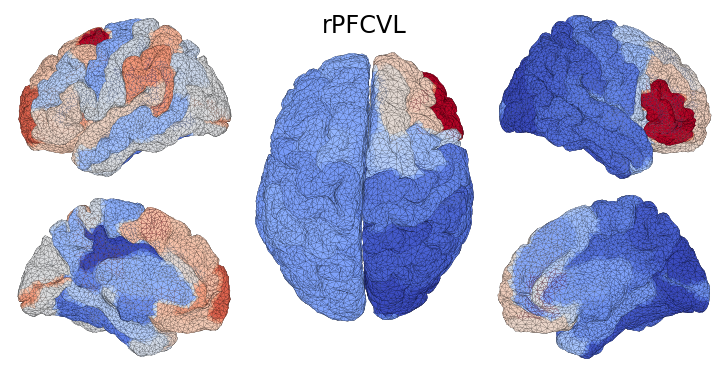

In [11]:
plot_roi_corr_map('rPFCVL') # lM1  rPCS